In [2]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt


In [3]:
#%%

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]

# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]

# %%

# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 
#shape[(24, 4794, 1) (24, 4794, 1) (4794, 5) (24, 4794, 1)]

In [4]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

In [5]:
all_new_features = np.concatenate((time_series_1_sun_average ,outdoor_conditions_stacked), axis=2)# concatenate the input for the model
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 6)
(12, 4794, 1)


In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [7]:
# take the traning data 
all_new_features_train=all_new_features[0:12, :, :].astype(np.float32)
all_new_features_train= torch.from_numpy(all_new_features_train).float().to(device)
target = torch.from_numpy(outdoor_panels_power_average[0:12, :, :]).float().to(device)

scaler1 = StandardScaler()
 

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True))
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True))

        # Define fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 32)  # Fully connected layer 2
        self.fc3 = nn.Linear(32, output_dim)  # Fully connected layer 3
        self.leaky_relu = nn.LeakyReLU(0.001)
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight)
            if m.bias is not None:
                # Initialize the bias with a random number between 0 and 1
                init.constant_(m.bias, 0)
          elif isinstance(m, nn.LSTM):
              for name, param in m.named_parameters():
                 if 'weight' in name:
                   init.kaiming_normal_(param)
                 elif 'bias' in name:
                    # Initialize the bias with a random number between 0 and 1
                    init.constant_(param, 0)
    def silu(self, x):
        return x * torch.sigmoid(x)
    def forward(self, x):
        # Iterate through LSTM layers
        for i in range(self.num_layers):
            if i == 0:
                lstm_output, _ = self.lstm_layers[i](x)  # Apply the first LSTM layer
            else:
                lstm_output, _ = self.lstm_layers[i](lstm_output)  # Apply subsequent LSTM layers
        
        # Apply fully connected layers
        output = self.fc1(lstm_output)  # Apply fully connected layer 1
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc2(output)  # Apply fully connected layer 2
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc3(output)  # Apply fully connected layer 3
        
        return output




 







Mean Squared Error (MSE): 1.000056505203247


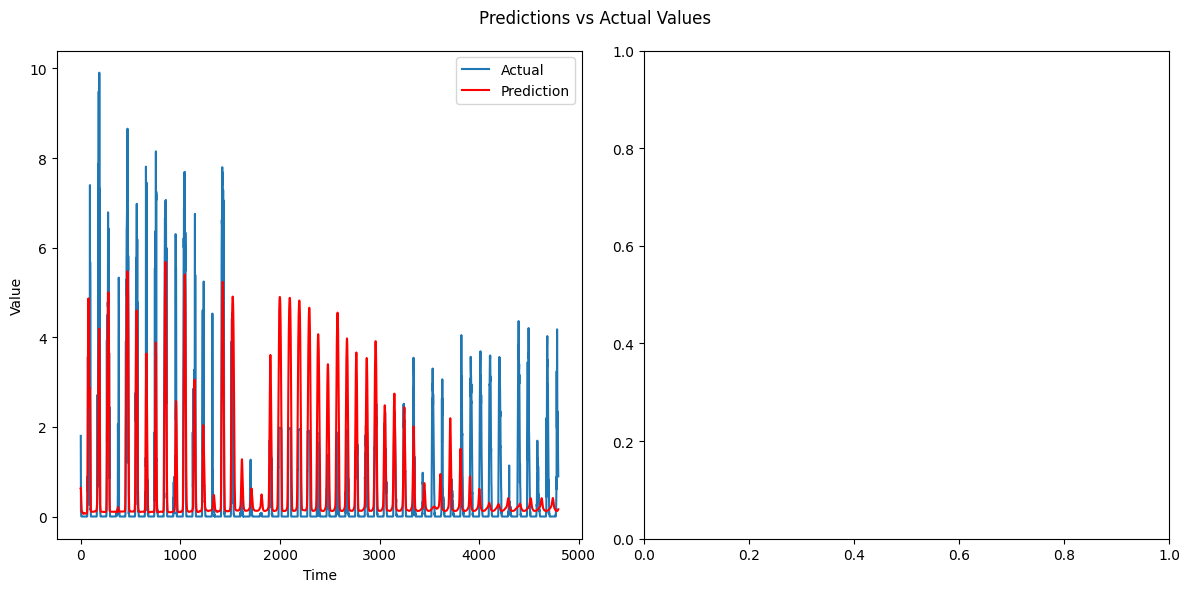

Mean Squared Error (MSE): 0.5924049615859985


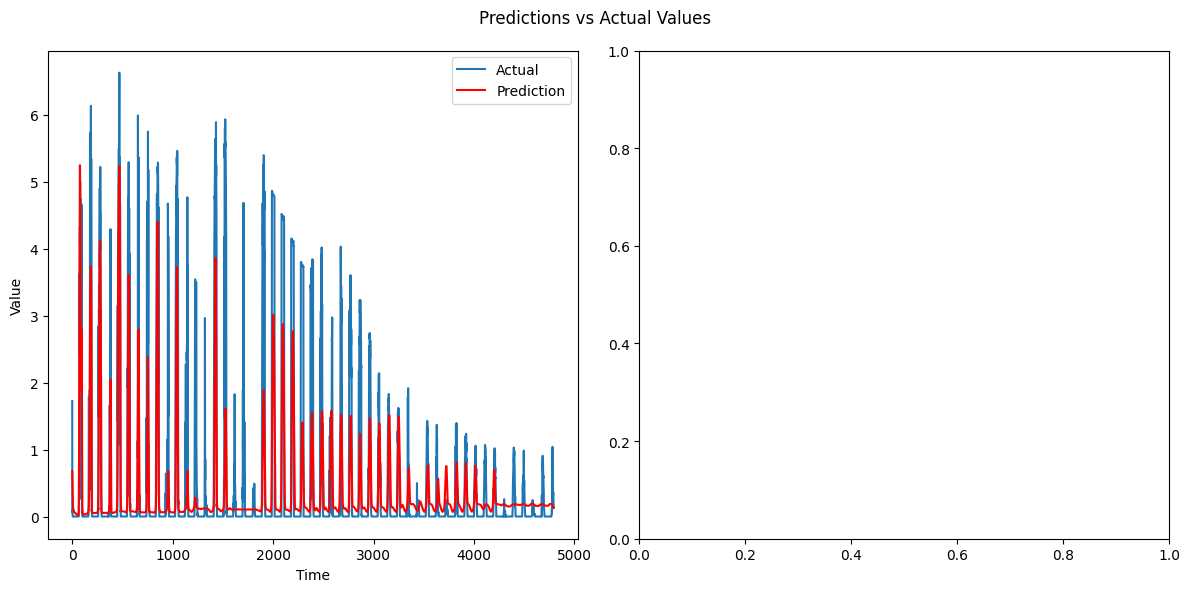

Mean Squared Error (MSE): 2.7063493728637695


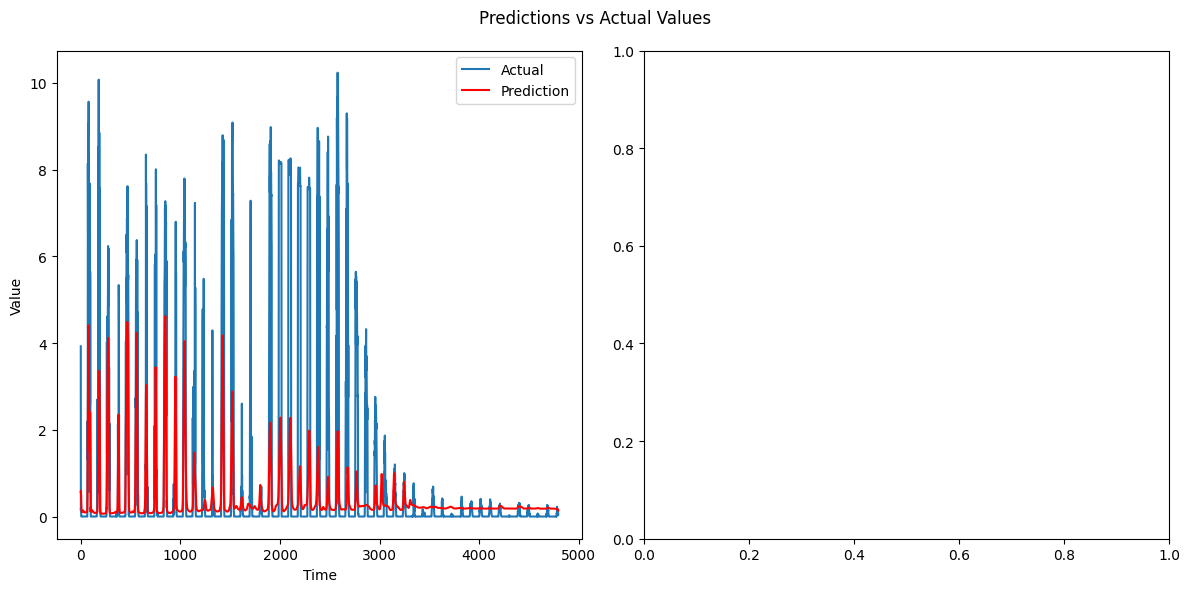

Mean Squared Error (MSE): 4.971673965454102


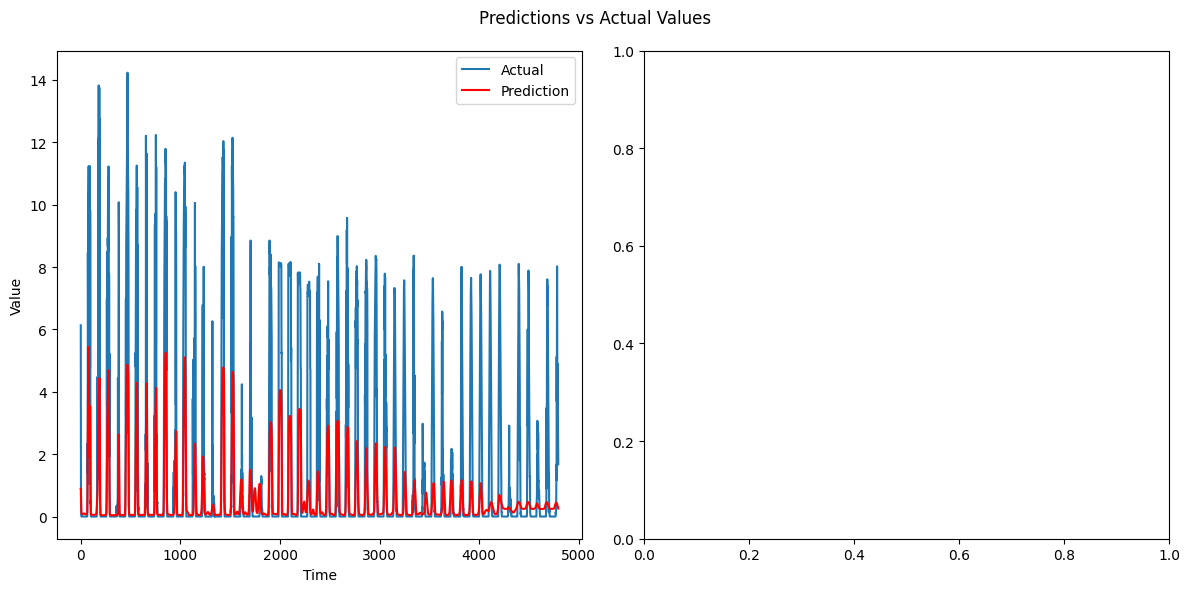

Mean Squared Error (MSE): 2.930137872695923


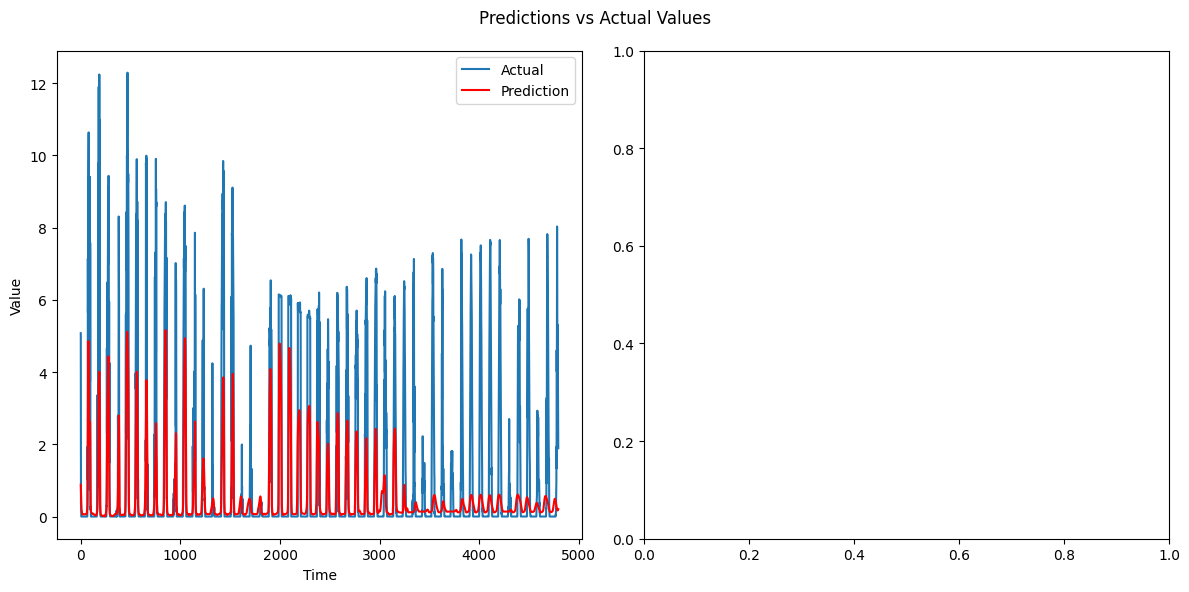

Mean Squared Error (MSE): 1.1921098232269287


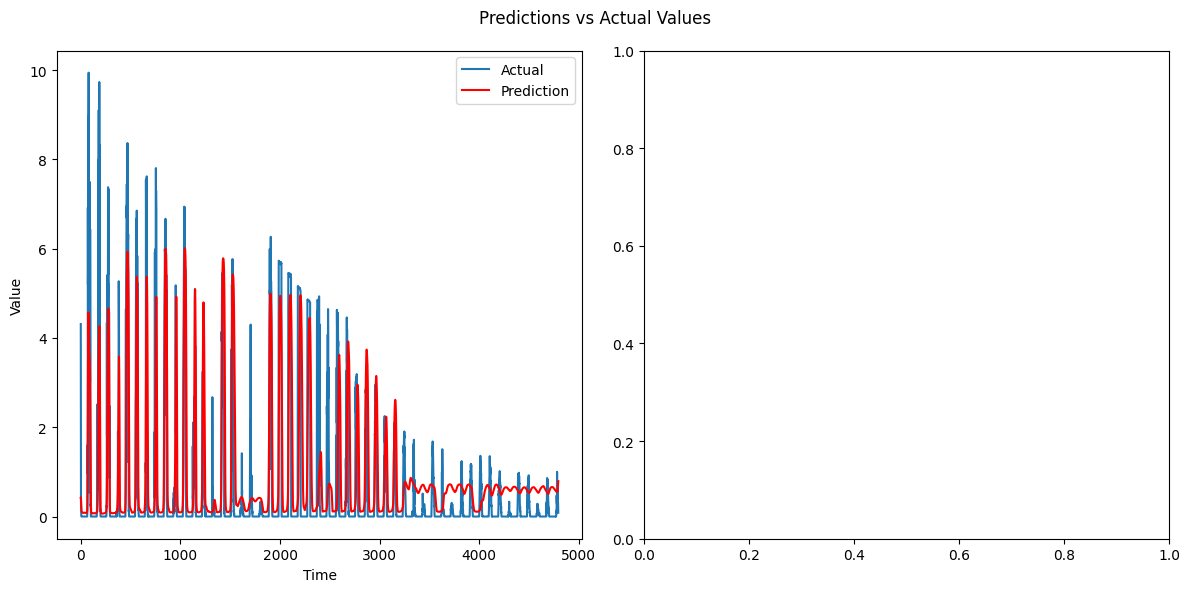

In [9]:
input_dim = 6  # number of features in the outdoor conditions and the indoor measurements
hidden_dim = 128
output_dim = 1  # the number of features in the output
num_epochs = 180
num_layers = 4
num_mixtures = 5
learning_rate = 0.001
weight_decay = 0.001
Fold = 0
Predictions = np.zeros((6, 4794, 1))
Test = np.zeros((6, 4794, 1))
kf = KFold(n_splits=12)




# Define the loss function and optimizer
 

# Split the data into 10 folds using K-Fold cross-validation
for train_index, test_index in kf.split(all_new_features_train):
    train_input = all_new_features_train[train_index]
    train_target = target[train_index]
    test_input = all_new_features_train[test_index]
    test_target = target[test_index]
    model= LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model in training mode
        outputs = model(train_input)
        outputs = outputs.view(train_input.shape[0], 4794, 1)
        loss = criterion(outputs, train_target)
        optimizer.zero_grad()
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    model.eval()  # Set the model in evaluation mode for testing
    with torch.no_grad():
        sample_input = test_input
        predictions = model(sample_input)
        Predictions[Fold] = predictions.numpy()
        Test[Fold] = test_target.numpy()
        mse = F.mse_loss(predictions, test_target)
        print("Mean Squared Error (MSE):", mse.item())

        # Plotting the predictions against the actual values
        x = range(test_target.shape[1])
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        for i, axs in enumerate(axs.flat):
            axs.plot(x, test_target[i].flatten(), label='Actual')
            axs.plot(x, predictions[i].flatten(), label='Prediction', color='red')
            axs.set_xlabel('Time')
            axs.set_ylabel('Value')
            axs.legend()
            break
        fig.suptitle('Predictions vs Actual Values')
        plt.tight_layout()
        plt.show()

        Fold += 1

        # If Fold reaches 2, stop the training loop (for demonstration purposes)
        if Fold == 6:
            break


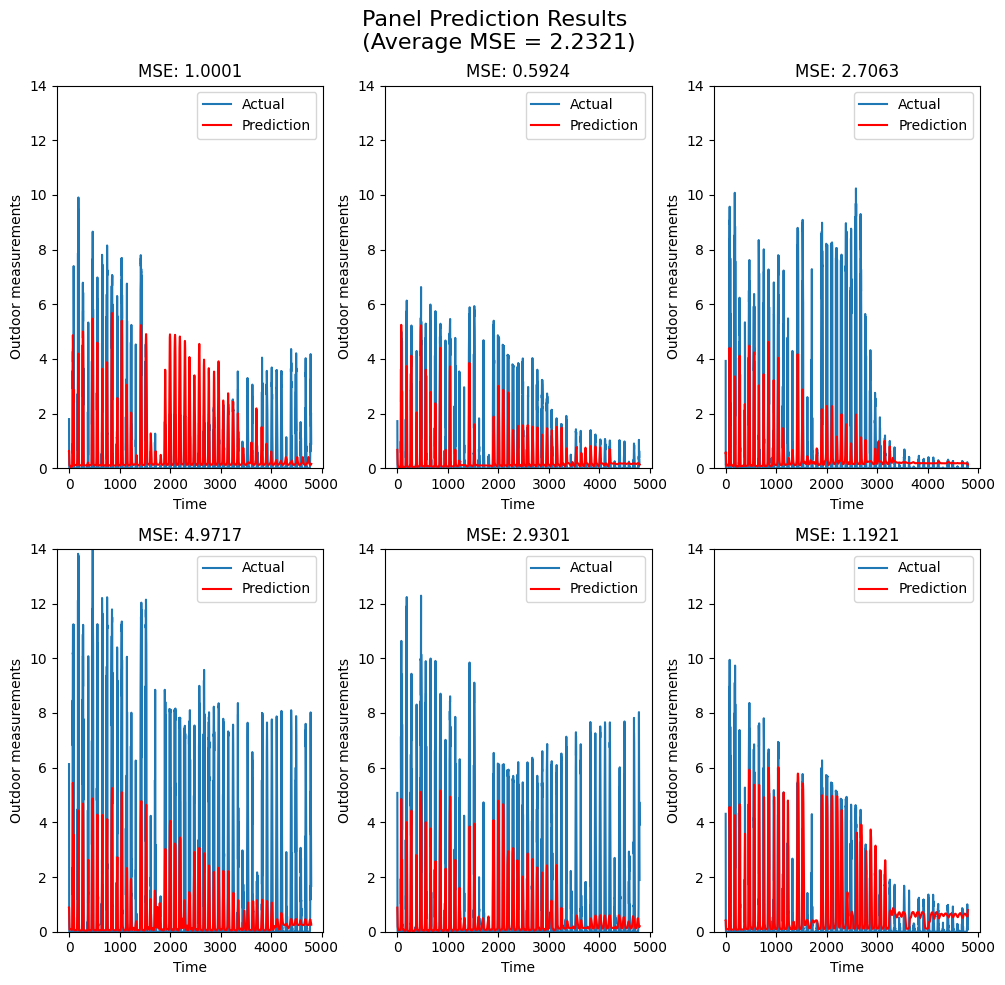

In [16]:
# Plot the predictions from the training set
x = range(Predictions.shape[1])
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
mse_scores = []

# Iterate over each panel's predictions
for i, ax in enumerate(axs.flat):  # <-- Fix: Use "ax" here instead of "axs"
    # Plot the actual values and predictions for the current panel
    ax.plot(x, Test[i], label='Actual')
    ax.plot(x, Predictions[i], label='Prediction', color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Outdoor measurements')
    ax.legend()
    ax.set_ylim(0, 14)
    
    # Calculate the Mean Squared Error (MSE) for the current panel's predictions
    mse = F.mse_loss(torch.tensor(Predictions[i]), torch.tensor(Test[i]))
    mse_scores.append(mse.item())
    
    # Set the title for the current panel's plot with the calculated MSE
    ax.set_title('MSE: {:.4f}'.format(mse.item()))  # <-- Fix: Use "ax" here instead of "axs"

# Calculate the average MSE error for all panels

# Set the figure title with the average MSE error
plt.suptitle("Panel Prediction Results\n (Average MSE = {:.4f})".format(np.mean(mse_scores)), fontsize=16)

# Save the plot as "training.pdf" in the current working directory
plt.savefig('test.pdf')

# Ensure the plots are displayed neatly without overlapping
plt.tight_layout()

# Show the plot
plt.show()
